In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
%ls

sample_data/


In [3]:
# read the dataset 
import pandas as pd
import numpy as np

#read the csv file
df_in = pd.read_csv( "sample_data/8_11_Data.csv")
df_in.drop( "Time" , inplace=True , axis=1 )
#remove nan data rows from the data frame
df_in["Prediction"] = df_in["Prediction"].astype('str')
df_in["Prediction"].replace( "nan" , np.nan, inplace=True)
df_in = df_in[ pd.notnull(df_in['Prediction']) ]
df_in = df_in.reset_index(drop=True)

In [4]:
#simple visualization on the data distribution
from sklearn.preprocessing import StandardScaler

def scale_data( data_in ):
  # scale data into common gaussian scale
  scaler = StandardScaler()
  data_out = scaler.fit_transform(data_in.values.reshape(-1,1))
  print(scaler.mean_ , scaler.var_ )

  return data_out

# generate new data frame with scaled data
df_scaled = pd.DataFrame()

#save scaled data into a new dataframe
for i_df_col in df_in.columns :
  if(i_df_col != "Prediction"):
    df_scaled[ i_df_col ] = scale_data( df_in[ i_df_col ] ).reshape(-1)
  else:
    df_scaled[i_df_col] = df_in[i_df_col]

[0.85020781] [0.06801826]
[0.49047973] [0.02439912]
[0.55461076] [0.0286541]
[122.86378239] [1865.33498448]
[51.6677048] [2532.70516074]
[154.44922748] [522.4068379]


In [5]:
df_in

,Feet Visibility,Shldr X,rtToe Y,Right SEW,Right WSR,Right HKA,Prediction
0,0.385548,0.429884,0.447916,129.710222,57.493582,161.387823,Empty
1,0.446362,0.461349,0.584364,174.051083,105.008016,174.625275,Empty
2,0.463897,0.317894,0.515401,172.259475,25.589399,152.303624,Empty
3,0.502354,0.335507,0.554987,177.511432,4.163114,179.104864,Empty
4,0.527357,0.341127,0.518868,176.078734,12.256284,161.003142,Empty
...,...,...,...,...,...,...,...
1207,0.980843,0.497169,0.496738,105.028486,151.537722,140.534669,SET
1208,0.977936,0.495168,0.491276,179.186707,144.769124,169.578289,0.85
1209,0.976403,0.488936,0.495215,177.266960,136.806500,168.041268,0.85
1210,0.974916,0.494518,0.494688,175.168894,136.616778,169.823393,0.85


In [6]:
df_scaled

,Feet Visibility,Shldr X,rtToe Y,Right SEW,Right WSR,Right HKA,Prediction
0,-1.781649,-0.387934,-0.630301,0.158521,0.115763,0.303576,Empty
1,-1.548470,-0.186496,0.175766,1.185179,1.059896,0.882738,Empty
2,-1.481235,-1.104886,-0.231631,1.143696,-0.518188,-0.093874,Empty
3,-1.333778,-0.992131,0.002223,1.265299,-0.943938,1.078728,Empty
4,-1.237912,-0.956150,-0.211154,1.232126,-0.783123,0.286745,Empty
...,...,...,...,...,...,...,...
1207,0.500896,0.042826,-0.341884,-0.412954,1.984462,-0.608786,SET
1208,0.489750,0.030017,-0.374152,1.304088,1.849967,0.661923,0.85
1209,0.483871,-0.009883,-0.350884,1.259638,1.691746,0.594676,0.85
1210,0.478170,0.025854,-0.353994,1.211060,1.687976,0.672647,0.85


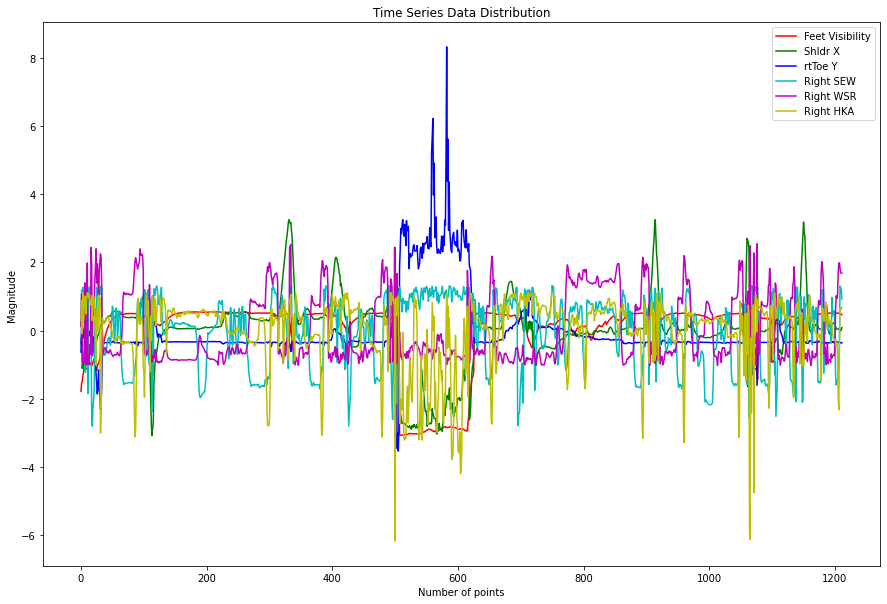

In [8]:
# simple data visualization

# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math
figure = plt.figure( figsize=(15,10) )
X = np.arange( len(df_scaled) )
  
# Plotting both the curves simultaneously
plt.plot(X, df_scaled["Feet Visibility"], color='r', label='Feet Visibility')
plt.plot(X, df_scaled["Shldr X"] , color='g', label='Shldr X')
plt.plot(X, df_scaled["rtToe Y"] , color='b', label='rtToe Y')
plt.plot(X, df_scaled["Right SEW"] , color='c', label='Right SEW')
plt.plot(X, df_scaled["Right WSR"] , color='m', label='Right WSR')
plt.plot(X, df_scaled["Right HKA"] , color='y', label='Right HKA')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of points")
plt.ylabel("Magnitude")
plt.title("Time Series Data Distribution")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [9]:
#split the dataset into train and validation
split_time = int( len(df_scaled)*0.8 )
# our prediction data
Y = df_scaled["Prediction"].values
# remove the prediction column from the data frame
df_scaled.drop( "Prediction" , inplace=True , axis=1)
X = df_scaled.values

In [10]:
from sklearn import preprocessing

# convert each text class into numerical values using label encoder 
le = preprocessing.LabelEncoder()
le.fit( np.array( Y.reshape(-1) , dtype=str)  )
print("Classes ",list(le.classes_) )

encoded_Y = np.array( le.transform( np.array(Y.reshape(-1) , dtype=str)  ) , dtype= "int" )

Classes  ['0.65', '0.75', '0.85', '0.9', '0.95', 'Dribbling', 'Empty', 'Pre-Set', 'SET']


In [11]:
from tensorflow.keras.utils import to_categorical

# devide the dataset to train and validation
x_train = X[:split_time]
y_train = encoded_Y[:split_time]
x_valid = X[split_time:]
y_valid = encoded_Y[split_time:]

# define the dataet window size and batch size
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# concatenate the x and target onehot encoded data
train_data = np.concatenate( (x_train , to_categorical(y_train,num_classes=9).reshape(-1,9)) , axis=1 )
valid_data = np.concatenate( (x_valid , to_categorical(y_valid,num_classes=9).reshape(-1,9)) , axis=1 )

In [12]:
# windowed the dataset for better model training to show the model temporal effect
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    ds = tf.data.Dataset.from_tensor_slices(series)
    # windowed the data frame
    ds = ds.window(window_size , shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size ))
    #ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:,:6], w[-1,6:]  ))
    return ds.batch(batch_size).prefetch(1)

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 32
batch_size = 32
# get the train and validation data sets
train_set = windowed_dataset( train_data , window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset( valid_data , window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 6), (None, 9)), types: (tf.float64, tf.float64)>
(969, 6)


In [15]:
def data_preprocessing( dataset_path , window_size , batch_size ):

  #read the csv file
  df_in = pd.read_csv( dataset_path  )
  df_in.drop( "Time" , inplace=True , axis=1 )
  #remove nan data rows from the data frame
  df_in["Prediction"] = df_in["Prediction"].astype('str')
  df_in["Prediction"].replace( "nan" , np.nan, inplace=True)
  df_in = df_in[ pd.notnull(df_in['Prediction']) ]
  df_in = df_in.reset_index(drop=True)

  # generate new data frame with scaled data
  df_scaled = pd.DataFrame()

  #save scaled data into a new dataframe
  for i_df_col in df_in.columns :
    if(i_df_col != "Prediction"):
      df_scaled[ i_df_col ] = scale_data( df_in[ i_df_col ] ).reshape(-1)
    else:
      df_scaled[i_df_col] = df_in[i_df_col]

  #split the dataset into train and validation
  split_time = int( len(df_scaled)*0.8 )
  # our prediction data
  Y = df_scaled["Prediction"].values
  # remove the prediction column from the data frame
  df_scaled.drop( "Prediction" , inplace=True , axis=1)
  X = df_scaled.values

  from sklearn import preprocessing

  # convert each text class into numerical values using label encoder 
  le = preprocessing.LabelEncoder()
  le.fit( np.array( Y.reshape(-1) , dtype=str)  )
  print("Classes ",list(le.classes_) )

  encoded_Y = np.array( le.transform( np.array(Y.reshape(-1) , dtype=str)  ) , dtype= "int" )

  from tensorflow.keras.utils import to_categorical

  # divide the dataset to train and validation
  x_train = X[:split_time]
  y_train = encoded_Y[:split_time]
  x_valid = X[split_time:]
  y_valid = encoded_Y[split_time:]

  # define the dataet window size and batch size
  shuffle_buffer_size = 1000

  # concatenate the x and target onehot encoded data
  train_data = np.concatenate( (x_train , to_categorical(y_train,num_classes=9).reshape(-1,9)) , axis=1 )
  valid_data = np.concatenate( (x_valid , to_categorical(y_valid,num_classes=9).reshape(-1,9)) , axis=1 )

  tf.keras.backend.clear_session()
  tf.random.set_seed(51)
  np.random.seed(51)

  # get the train and validation data sets
  train_set = windowed_dataset( train_data , window_size, batch_size, shuffle_buffer_size)
  valid_set = windowed_dataset( valid_data , window_size, batch_size, shuffle_buffer_size)
  

  return train_set , valid_set 

In [16]:
train_set , valid_set= data_preprocessing( "sample_data/8_11_Data.csv" , window_size=32 , batch_size=32  )

[0.85020781] [0.06801826]
[0.49047973] [0.02439912]
[0.55461076] [0.0286541]
[122.86378239] [1865.33498448]
[51.6677048] [2532.70516074]
[154.44922748] [522.4068379]
Classes  ['0.65', '0.75', '0.85', '0.9', '0.95', 'Dribbling', 'Empty', 'Pre-Set', 'SET']


In [17]:
x, y = next(iter(valid_set))

In [18]:
# print out the shapes
print("Output X shape ",x.shape)
print("Output y shape ",y.shape)

Output X shape  (32, 32, 6)
Output y shape  (32, 9)


In [19]:
import matplotlib.pyplot as plt

def plot_loss_accuracy( acc , val_acc , loss , val_loss ) :
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,5.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

## Conv 1D + RNN + Dense Model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# time series model with conv1d --> simple rnn layers --> dense layers
model_rnn = tf.keras.models.Sequential([
  # conv 1d layer with kernel size 5                                     
  tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="same",
                      activation="relu",
                      input_shape=[None, 6]),
  # simple rnn layers
  tf.keras.layers.SimpleRNN( 128, return_sequences=True),
  tf.keras.layers.SimpleRNN(64, return_sequences=False),
  # dense layer
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(9 , activation="softmax")
])

# adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

# early stopping based on validation loss
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
# best model saving check point
mcp_save = ModelCheckpoint('time_rnn_dense.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# compile the model with categorical crossentropy loss becuase this is a classification model
model_rnn.compile(loss=tf.keras.losses.categorical_crossentropy ,
              optimizer=optimizer,
              metrics=["accuracy"])
# model training
history_rnn_dense = model_rnn.fit(train_set, epochs=150 , validation_data= valid_set,
                   callbacks=[ mcp_save ])
model_rnn.summary

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
30/30 [==============================] - 4s 51ms/step - loss: 1.3451 - accuracy: 0.4403 - val_loss: 1.2947 - val_accuracy: 0.5660
Epoch 2/150
30/30 [==============================] - 1s 37ms/step - loss: 0.7941 - accuracy: 0.7441 - val_loss: 1.1564 - val_accuracy: 0.6038
Epoch 3/150
30/30 [==============================] - 1s 35ms/step - loss: 0.6647 - accuracy: 0.7751 - val_loss: 1.1184 - val_accuracy: 0.6085
Epoch 4/150
30/30 [==============================] - 1s 35ms/step - loss: 0.5838 - accuracy: 0.7910 - val_loss: 1.4333 - val_accuracy: 0.5613
Epoch 5/150
30/30 [==============================] - 1s 34ms/step - loss: 0.4958 - accuracy: 0.8156 - val_loss: 1.3220 - val_accuracy: 0.6038
Epoch 6/150
30/30 [==============================] - 1s 34ms/step - loss: 0.4286 - accuracy: 0.8593 - val_loss: 1.1683 - val_accuracy: 0.6745
Epoch 7/150
30/30 [==============================] - 1s 34ms/step - loss: 0.4373 - accuracy: 0.8507 - val_loss: 1.1753 - val_accuracy: 0.6604
Epoch 

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fac0a5968d0>>

In [23]:
!mkdir json_rnn

In [24]:
!pip install tensorflowjs

import tensorflowjs as tfjs
import os
import keras
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras.backend as K

#K.backend.clear_session()  # this resets the session containing the stale, not-best version of the model 

model=load_model('/content/time_rnn_dense.h5')# path to model

tfjs.converters.save_keras_model(model, '/content/json_rnn')

     |████████████████████████████████| 64 kB 3.3 MB/s 


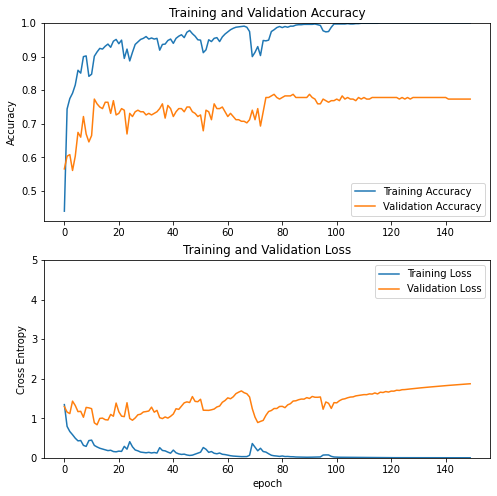

In [25]:
acc = history_rnn_dense.history['accuracy']
val_acc = history_rnn_dense.history['val_accuracy']

loss = history_rnn_dense.history['loss']
val_loss = history_rnn_dense.history['val_loss']

plot_loss_accuracy( acc , val_acc , loss , val_loss )

## Conv 1D + LSTM + Dense Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau

# conv1d --> lstm layer --> dense layer
model = tf.keras.models.Sequential([
  # conv 1d layer
  tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="same",
                      activation="relu",
                      input_shape=[None, 6]),
  # lstm layers
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=False),
  #dense layer
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(9 , activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(lr=1e-3)

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('time_lstm_dense.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.compile(loss=tf.keras.losses.categorical_crossentropy ,
              optimizer=optimizer,
              metrics=["accuracy"])

history_lstm_dense = model.fit(train_set, epochs=150 , validation_data= valid_set,
                    callbacks=[ mcp_save ])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
30/30 [==============================] - 7s 125ms/step - loss: 1.3188 - accuracy: 0.5832 - val_loss: 1.4214 - val_accuracy: 0.5189
Epoch 2/150
30/30 [==============================] - 3s 85ms/step - loss: 0.7868 - accuracy: 0.7548 - val_loss: 1.3465 - val_accuracy: 0.5330
Epoch 3/150
30/30 [==============================] - 2s 83ms/step - loss: 0.5901 - accuracy: 0.7964 - val_loss: 1.2630 - val_accuracy: 0.5849
Epoch 4/150
30/30 [==============================] - 3s 85ms/step - loss: 0.4648 - accuracy: 0.8230 - val_loss: 1.2014 - val_accuracy: 0.6415
Epoch 5/150
30/30 [==============================] - 3s 86ms/step - loss: 0.4276 - accuracy: 0.8326 - val_loss: 1.1532 - val_accuracy: 0.6085
Epoch 6/150
30/30 [==============================] - 3s 86ms/step - loss: 0.3994 - accuracy: 0.8891 - val_loss: 1.1344 - val_accuracy: 0.6132
Epoch 7/150
30/30 [==============================] - 3s 84ms/step - loss: 0.4631 - accuracy: 0.8380 - val_loss: 1.2374 - val_accuracy: 0.5849
Epoch

In [27]:
!mkdir json_lstm

In [28]:
import tensorflowjs as tfjs
import os
import keras
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras.backend as K

#K.backend.clear_session()  # this resets the session containing the stale, not-best version of the model 

model=load_model('/content/time_lstm_dense.h5')# path to model

tfjs.converters.save_keras_model(model, '/content/json_lstm')

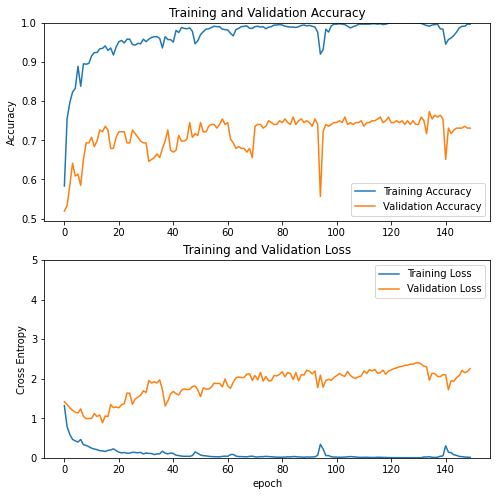

In [29]:
acc = history_lstm_dense.history['accuracy']
val_acc = history_lstm_dense.history['val_accuracy']

loss = history_lstm_dense.history['loss']
val_loss = history_lstm_dense.history['val_loss']

plot_loss_accuracy( acc , val_acc , loss , val_loss )

In [30]:
model_conv1d_gru_dense = tf.keras.models.Sequential([

  # two conv1d layers                                                       
  tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="same",
                      activation="relu",
                      input_shape=[None, 6]),

  tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="same",
                      activation="relu"),
  # gru layers
  tf.keras.layers.GRU(256, return_sequences=True , reset_after=False),
  tf.keras.layers.GRU(256, return_sequences=False, reset_after=False),
  # add dropout layers for avoid making model overfitting
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.3) ,
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5) ,
  tf.keras.layers.Dense(9 , activation="softmax")

])


optimizer = tf.keras.optimizers.Adam(lr=1e-3)

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('time_gru_dense.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, verbose=1, epsilon=1e-4, mode='min')

model_conv1d_gru_dense.compile(loss=tf.keras.losses.categorical_crossentropy ,
              optimizer=optimizer,
              metrics=["accuracy"])

history_conv1d_gru_dense = model_conv1d_gru_dense.fit(train_set, epochs=100 , validation_data= valid_set,
                    callbacks=[ mcp_save ])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
30/30 [==============================] - 16s 431ms/step - loss: 1.3101 - accuracy: 0.6631 - val_loss: 1.2807 - val_accuracy: 0.5613
Epoch 2/100
30/30 [==============================] - 12s 406ms/step - loss: 0.9091 - accuracy: 0.7207 - val_loss: 1.2043 - val_accuracy: 0.6038
Epoch 3/100
30/30 [==============================] - 12s 405ms/step - loss: 0.7002 - accuracy: 0.7548 - val_loss: 1.2685 - val_accuracy: 0.6132
Epoch 4/100
30/30 [==============================] - 13s 420ms/step - loss: 0.5808 - accuracy: 0.8209 - val_loss: 1.2724 - val_accuracy: 0.6745
Epoch 5/100
30/30 [==============================] - 12s 415ms/step - loss: 0.5317 - accuracy: 0.8348 - val_loss: 1.0399 - val_accuracy: 0.6698
Epoch 6/100
30/30 [==============================] - 13s 423ms/step - loss: 0.4940 - accuracy: 0.8550 - val_loss: 0.9628 - val_accuracy: 0.6415
Epoch 7/100
30/30 [==============================] - 13s 426ms/step - loss: 0.6371 - accuracy: 0.8166 - val_loss: 0.9880 - val_accuracy:

In [ ]:
!!pip install tensorflowjs

In [31]:
import tensorflowjs as tfjs
import os
import keras
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras.backend as K

#K.backend.clear_session()  # this resets the session containing the stale, not-best version of the model 

model=load_model('/content/time_gru_dense.h5')# path to model

tfjs.converters.save_keras_model(model, '/content/json_model')

In [32]:
tfjs.__version__

'3.9.0'

In [33]:
#convert into tf json format
!tensorflowjs_converter --input_format=keras "/content/time_gru_dense.h5" "/content/json_model"

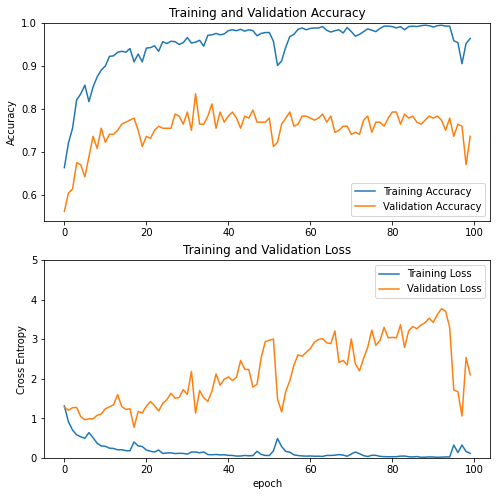

In [34]:
acc = history_conv1d_gru_dense.history['accuracy']
val_acc = history_conv1d_gru_dense.history['val_accuracy']

loss = history_conv1d_gru_dense.history['loss']
val_loss = history_conv1d_gru_dense.history['val_loss']

plot_loss_accuracy( acc , val_acc , loss , val_loss )